# Fit model of auxotrophic communities to data from range expansions experiments

We fit in total 5 parameters to the data:

- fit leakage rate of trp and pro are fitted to simultaneously to  community's A (dT+dP) equilibrium fraction and growth defect (expansion range dP+dT / expansion range WT). These were originally fitted to growth rates observed in microfluidic chambers but we expect effective leakage rates to be lower for colonies as the agar acts as a sink. 
- fit increase in pro uptake caused by putP over expression by fitting model to change in relative sector size (range dP / range dT) between community A (dT+dT) and B (dP-pEP17-putP + dT)
- fit increase in trp leakage caused by trpR deletion by fitting model to equilibrium fraction of community C (dT + dP-trpR)
- fit increase in pro leakage caused by proB74 mutation by fitting model to equilibrium fraction of community E (dT-proB74 + dP)

Note: equation numbers refer to main text of van Vliet et al Plos Comp Bio 2022.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))

## Load Data and set experimentally measured parameters

In [11]:
#init dictionary to store fit parameters
fit_pars = {} # parameters for the fit

#load dictionary width measured growth rates
with open('growth_rates.txt', 'r') as file:
    growth_rates = eval(file.read())

#load data
df_all = pd.read_csv('community_data.csv')

#average over technical replicates
df_all['Identifier'] = df_all.apply(lambda row: f"{row['Condition']}-{row['Rep']}", axis=1)
df = df_all.groupby('Identifier').agg({'Width': 'mean', 'dT_patch': 'mean', 'dP_patch': 'mean', 'Ratio': 'mean', 'Condition': 'first', 'Rep': 'first'}).reset_index()

#add relative patch width
df['rel_range'] = df['dP_patch']/df['dT_patch']

#average over biological replicates
df_mean = df.groupby('Condition')[['Ratio', 'Width', 'dT_patch', 'dP_patch', 'rel_range']].mean().reset_index()
df_mean.head(n=9)

,Condition,Ratio,Width,dT_patch,dP_patch,rel_range
0,A,0.259426,99.855962,9.642489,38.759026,4.066068
1,B,0.419124,165.937762,34.599521,22.536955,0.940167
2,C,0.590971,-0.490552,8.281197,19.247165,2.396698
3,D,0.625701,298.223025,9.188725,5.445170,0.656216
4,E,0.192119,803.814899,119.566868,491.048497,4.065417
5,F,0.387379,854.308375,134.352018,147.889317,1.109466
6,G,0.409993,846.470840,113.478865,189.711251,1.658255
7,H,0.403510,873.030570,133.066353,174.321082,1.297801
8,WT,0.542899,1083.484242,192.774160,782.705439,3.619530


## Define functions

In [4]:
def report_data(df, condition):
    '''Report data for a given condition'''
    df_sum = df[df['Condition']==condition]
    
    rel_growth = df_sum["Width"].mean()  / df.loc[df['Condition']=='WT']['Width'].mean() 
    sector_ratio = np.mean(df_sum['dP_patch'] / df_sum['dT_patch'])
    
    print(f"Experiments: C{condition:s}: f(dT) = {df_sum['Ratio'].mean() :.2f}, rel. growth = {rel_growth:.2f}, sectors dP = {df_sum['dP_patch'].mean() :.2f}um, sectors dT = {df_sum['dT_patch'].mean() :.2f}um, sector ratio = {sector_ratio:.2f}")
    return None

def fit_1D(x, y_data, y_model):
    ''' Fit 1D data'''
    L2_norm = (y_model - y_data)**2
    min_idx = np.argmin(L2_norm)
    
    fitted_x = x[min_idx]    
    fig, axs = plt.subplots(1,1,figsize=(5,3))
    
    axs.plot(x, y_model, label='model')
    axs.plot(x, np.ones_like(x) * y_data.mean(), label='data')
    axs.axvline(x=fitted_x, color='k', linestyle='--')
    
    if min_idx == x.size-1:
        fitted_x = np.nan
    
    return (fitted_x, min_idx)     

def fit_2D(x, y, z1, z2, z1_data, z2_data, log_scale=False):
    ''' Fit 2D data'''  
    delta1 = (z1 - z1_data)/z1_data
    delta2 = (z2 - z2_data)/z2_data
    L2_norm_comb = np.log10(delta1**2 + delta2**2)

    idx_y, idx_x = np.unravel_index(np.argmin(L2_norm_comb), L2_norm_comb.shape)
    xfit = x[idx_x]
    yfit = y[idx_y]

    fig,axs = plt.subplots(1,3,figsize=(15,5))

    im0 = axs[0].imshow(z1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im0, ax=axs[0])
    axs[0].contour(x, y, z1, levels=[z1_data.mean()], colors='r')
    axs[0].contour(x, y, z2, levels=[z2_data.mean()], colors='m')
    axs[0].axvline(x=xfit, color='k', linestyle='--')
    axs[0].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

    im1 = axs[1].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[1])
    axs[1].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[1].contour(x, y, z2, levels=[z2_data.mean()], colors='r')
    axs[1].axvline(x=xfit, color='k', linestyle='--')
    axs[1].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

    im2 = axs[2].imshow(L2_norm_comb, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    fig.colorbar(im2, ax=axs[2])
    axs[2].axvline(x=xfit, color='k', linestyle='--')
    axs[2].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[2].set_xscale('log')
        axs[2].set_yscale('log')

    return (xfit, yfit)

---
## Fit leakage rates to community A

We fit leakage rate of trp and pro are fitted to simultaneously to  community's A (dT+dP) equilibrium fraction and growth defect (expansion range dP+dT / expansion range WT). These were originally fitted to growth rates observed in microfluidic chambers but we expect effective leakage rates to be lower for colonies as the agar acts as a sink. 


Pro leakage = 9.59e-07 (original = 1.59e-05), Trp leakage = 9.53e-08 (original = 6.04e-07)

Model predictions for community A, fit leakage:
Frequency dT = 0.26
Clustering dT = 0.89, Clustering dP = 0.99
Growth relative to WT = 0.09
Growth defect spatial community = 0.93
mu_max dP = 0.10, mu_max dT = 0.04
range dP = 10.64um, range dT = 2.49um, range dP/dT = 4.27

Experimental measurements of community A:
Experiments: CA: f(dT) = 0.26, rel. growth = 0.09, sectors dP = 38.76um, sectors dT = 9.64um, sector ratio = 4.07


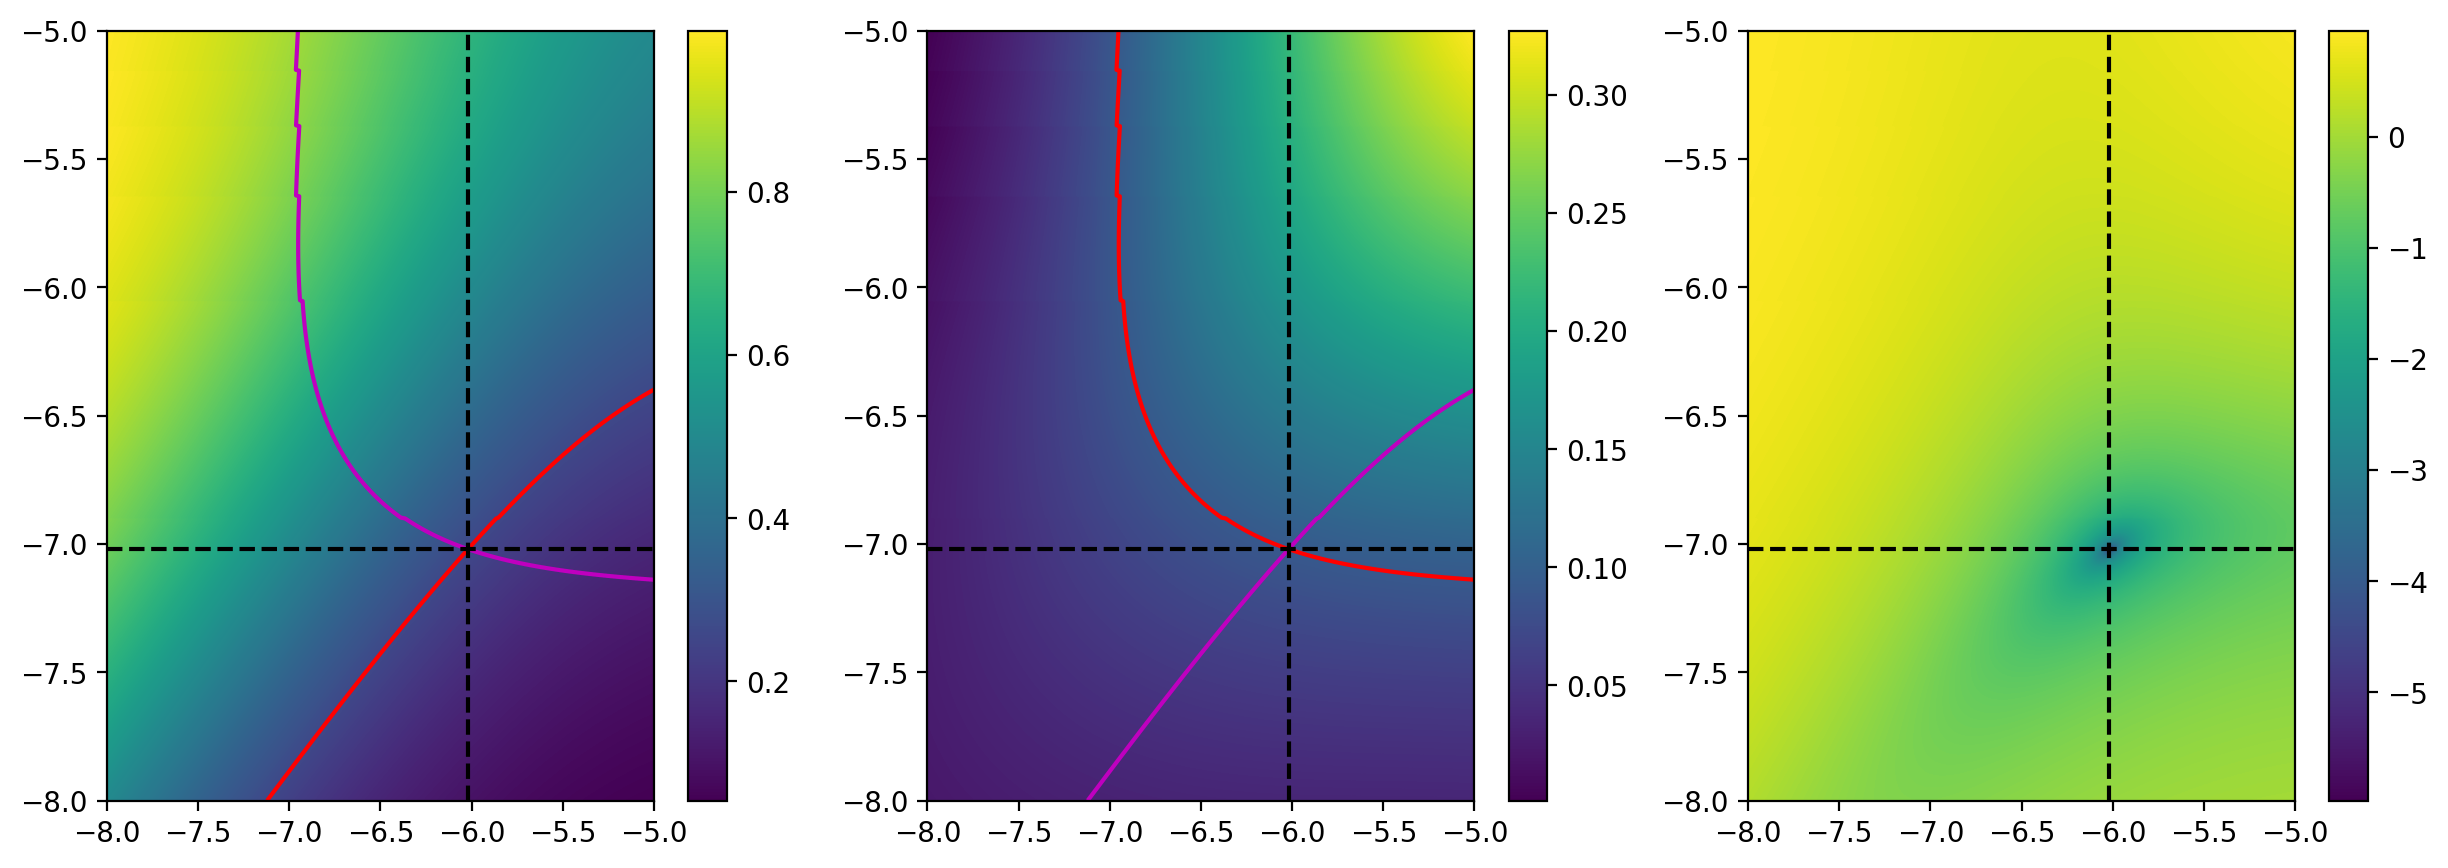

In [5]:

def_com = community() #baseline community

#perform 2d data fit, fit on log-transformed leakage rates
lPro = np.linspace(-8,-5,1000)
lTrp = np.linspace(-8,-5,1000)
xmat, ymat = np.meshgrid(lPro, lTrp)

#fit leakage parameters to equilibrium and relative growth data
eq_data = df_mean.loc[df_mean['Condition']=='A']['Ratio'].values[0] 
growth_data = df_mean.loc[df_mean['Condition']=='A']['Width'].values[0] / df_mean.loc[df_mean['Condition']=='WT']['Width'].values[0] 

#fit community
community_A0 = community(lPro=10**xmat, lTrp=10**ymat, 
                         mu_WT=growth_rates['WT'], 
                         mu_dT=growth_rates['dT'], 
                         mu_dP=growth_rates['dP'])

xfit, yfit = fit_2D(lPro, lTrp, community_A0.eq, community_A0.rel_growth_wt, eq_data, growth_data)
lPro_fit = 10**xfit
lTrp_fit = 10**yfit

fit_pars['lPro'] = lPro_fit
fit_pars['lTrp'] = lTrp_fit

#report fit parameters
print(f"Pro leakage = {lPro_fit:.3g} (original = {def_com.lPro:.3g}), Trp leakage = {lTrp_fit:.3g} (original = {def_com.lTrp:.3g})")

community_A0_fit = community( mu_WT=growth_rates['WT'], 
                             mu_dT=growth_rates['dT'], 
                             mu_dP=growth_rates['dP'],
                             lPro=fit_pars['lPro'], 
                             lTrp=fit_pars['lTrp'])

print('\nModel predictions for community A, fit leakage:')
community_A0_fit.report_properties()

print('\nExperimental measurements of community A:')
report_data(df, 'A')

---
## Characterize putP using community B

We fit increase in pro uptake caused by putP over expression by fitting model to change in relative sector size (range dP / range dT) between community A (dT+dT) and B (dP-pEP17-putP + dT)

c_up_P = 93.70, eqFrac = 0.42, sec_dP = 2.34, sec_dT = 0.94
Experiments: CB: f(dT) = 0.42, rel. growth = 0.15, sectors dP = 22.54um, sectors dT = 34.60um, sector ratio = 0.94


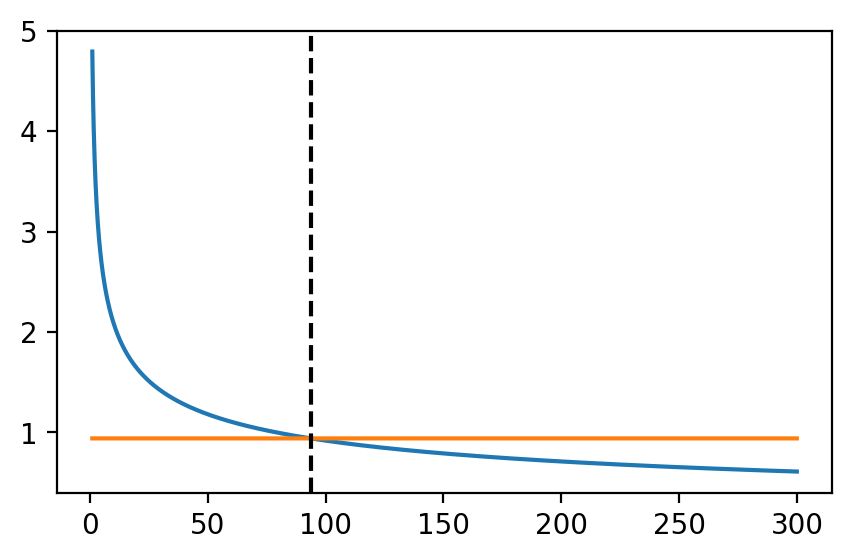

In [6]:
#community B
c_up_P = np.arange(1,300.1,0.1)

community_B0 = community(lPro=fit_pars['lPro'], 
                         lTrp=fit_pars['lTrp'], 
                         mu_WT=growth_rates['WT'], 
                         mu_dT=growth_rates['dT'], 
                         mu_dP=growth_rates['dP_proUp'], 
                         c_up_P=c_up_P)

y0 = community_B0.rangeP / community_B0.rangeT

#fit to relative range of dT/dP
rel_range_data = df_mean.loc[df_mean['Condition']=='B']['rel_range'].values[0] 
c_up_fit, idx0 = fit_1D(c_up_P, rel_range_data, y0)

fit_pars['c_up_P'] = c_up_fit 

#report fit parameters
print(f"c_up_P = {c_up_fit:.2f}, eqFrac = {community_B0.eq[idx0]:.2f}, sec_dP = {community_B0.rangeP[idx0]:.2f}, sec_dT = {community_B0.rangeP[idx0]/community_B0.rangeT:.2f}")
report_data(df, 'B')

----

## Characterize trpR using community C

We fit increase in trp leakage caused by trpR deletion by fitting model to equilibrium fraction of community C (dT + dP-trpR)

c_prod_T_P = 40.00, eqFrac = 0.59, relmu = 0.23
Experiments: CC: f(dT) = 0.59, rel. growth = -0.00, sectors dP = 19.25um, sectors dT = 8.28um, sector ratio = 2.40


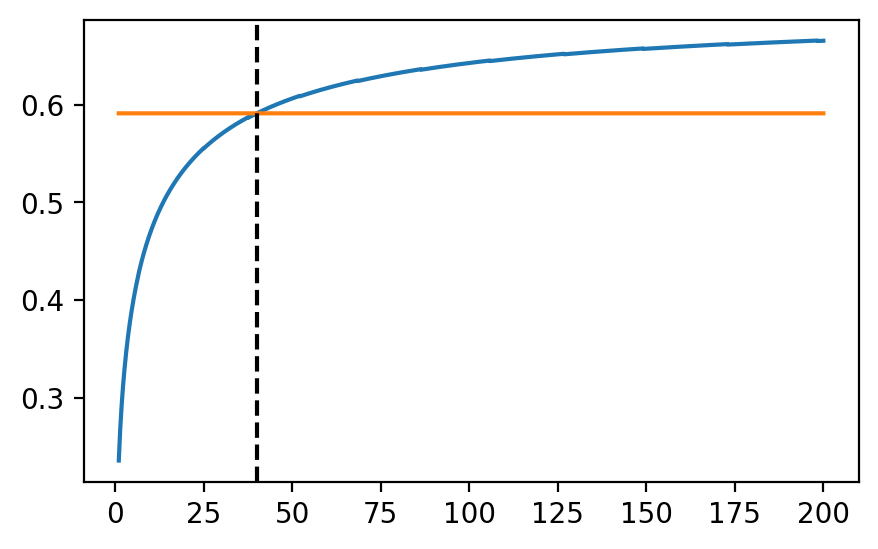

In [7]:
#get measured value
eq_data = df_mean.loc[df_mean['Condition']=='C']['Ratio'].values[0]

#fit equilibrium fraction community C
c_prod_T = np.arange(1,200.1,0.1)
community_C0 = community(lPro=fit_pars['lPro'], 
                         lTrp=fit_pars['lTrp'], 
                         mu_WT=growth_rates['WT'], 
                         mu_dT=growth_rates['dT'], 
                         mu_dP=growth_rates['dP_trpOP'], 
                         c_prod_T=c_prod_T)

c_prod_T_fit, idx0 = fit_1D(c_prod_T, eq_data, community_C0.eq)
fit_pars['c_prod_T'] = c_prod_T_fit 

#report fit parameters
print(f"c_prod_T_P = {c_prod_T_fit:.2f}, eqFrac = {community_C0.eq[idx0]:.2f}, relmu = {community_C0.rel_growth_wt[idx0]:.2f}")
report_data(df, 'C')

----

## Characterize proB74 using community E

We fit increase in pro leakage caused by proB74 mutation by fitting model to equilibrium fraction of community E (dT-proB74 + dP)

c_prod_P = 5.00, eqFrac = 0.19, relmu = 0.11
Experiments: CE: f(dT) = 0.19, rel. growth = 0.74, sectors dP = 491.05um, sectors dT = 119.57um, sector ratio = 4.07


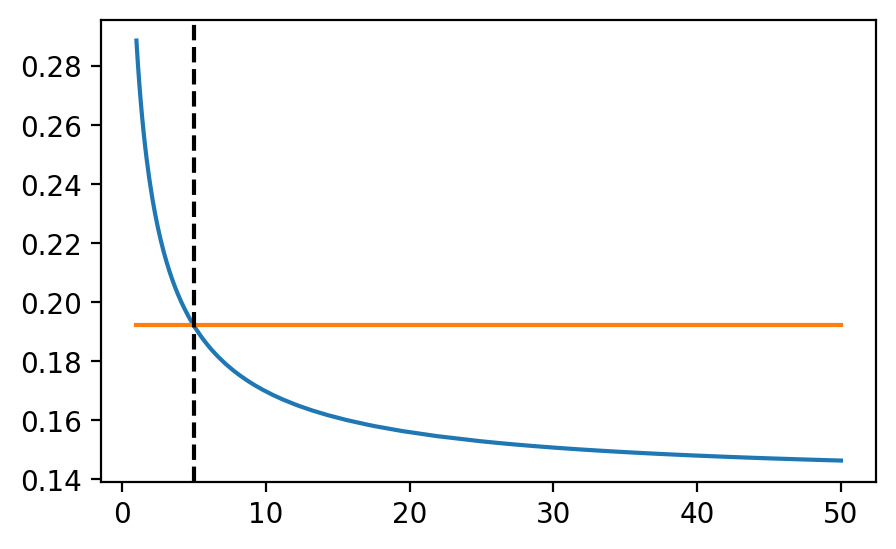

In [8]:
#get measured value
eq_data = df_mean.loc[df_mean['Condition']=='E']['Ratio'].values[0]

#ft equilibrium fraction community E
c_prod_P = np.arange(1,50.1,0.1)
community_E0 = community(lPro=fit_pars['lPro'], 
                         lTrp=fit_pars['lTrp'], 
                         mu_WT=growth_rates['WT'], 
                         mu_dT=growth_rates['dT_proOP'], 
                         mu_dP=growth_rates['dP'], 
                         c_prod_P=c_prod_P)

c_prod_P_fit, idx0 = fit_1D(c_prod_P, eq_data, community_E0.eq)
fit_pars['c_prod_P'] = c_prod_P_fit 

#report fit parameters
print(f"c_prod_P = {c_prod_P_fit:.2f}, eqFrac = {community_E0.eq[idx0]:.2f}, relmu = {community_E0.rel_growth_wt[idx0]:.2f}")
report_data(df, 'E')

---

## Report fitting results

In [9]:

#store pre-processed data
df_mean.to_csv('community_data_mean.csv', index=False)
#store parameter values
with open('fit_parameters.txt', 'w') as file:
    file.write(str(fit_pars))
    file.close()
#print parameters
print(fit_pars)

{'lPro': 9.593608287093148e-07, 'lTrp': 9.5275004724273e-08, 'c_up_P': 93.70000000000009, 'c_prod_T': 40.000000000000036, 'c_prod_P': 5.0000000000000036}
